In [199]:
!pip install -q kornia kornia-rs

In [229]:
import torch
import kornia as K
import albumentations as A
import albumentations.pytorch
import torchvision.transforms as T
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from collections import OrderedDict

import time
import pandas as pd
import plotly.express as px
from IPython.display import clear_output
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

### 1. Аугментации и прочие приколы

Как и другие библиотеки для cv, в kornia есть куча самых разных аугментаций, какие-то есть в похожих либах, типа albumentations, torchvision, opencv. Вполне возможно, что есть какие-то уникальные, так что если очень интересно, можно посмотреть

Самое на мой взгляд хорошее это то, что интерфейс здесь такой же, как в torchvision, так что после него переходить на kornia легко и приятно

In [237]:
def plot_images(org, img):

    fig, ax = plt.subplots(2, img.shape[0], sharex=True, sharey=True)
    fig.suptitle("Original (Top) / Trasnformed (Bottom)", fontsize=16)
    for b in range(img.shape[0]):
        ax[0, b].imshow(org[b])
        ax[1, b].imshow(img[b])

    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def augment(dataloader, transform, device="cuda"):
    images, targets = next(iter(dataloader))
    images = images.to(device)
    targets = targets.to(device)
    original = K.tensor_to_image(images)
    images = transform(images)
    images = K.tensor_to_image(images)
    plot_images(original, images)

Смотреть будем на рандомных картинках из CIFAR10. Его же будем потом использовать для обучения модели, потому что он достаточно маленький и достаточно простой для наших целей

In [239]:
dataset = torchvision.datasets.CIFAR10(
    './cifar100',
    train=True,
    download=True,
    transform=T.ToTensor()
)
print(dataset)
print(f"Image size: {dataset[0][0].shape}")
print(f"Num of classes: {len(dataset.classes)}")

loader = DataLoader(dataset, batch_size=8, shuffle=True)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar100
    Split: Train
    StandardTransform
Transform: ToTensor()
Image size: torch.Size([3, 32, 32])
Num of classes: 10


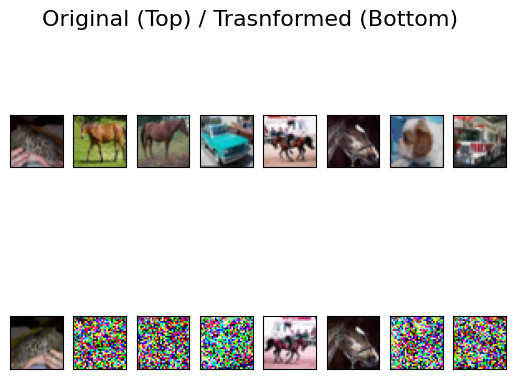

In [243]:
transform = nn.Sequential(
    K.augmentation.RandomHorizontalFlip(),
    K.augmentation.ColorJitter(0.1, 0.1, 0.1, 0.1),
    K.augmentation.RandomGaussianNoise()
).to("cuda")

augment(loader, transform)

Ещё kornia умеет аугментить на GPU, её можно завернуть в `nn.Sequential`, а потом перекинуть на мегадевайс. Albumentations вроде бы тоже умеет, но всё равно прикольно. Если следовать статье, то kornia можно распараллелить и тогда он будет даже превосходить по скорости, но у меня нет двух гпух, так что без него... Да и времени нет, чтобы мы прирост увидели

### 2. Обучение и другие интересности

Теперь посмотрим на то, как kornia ведёт себя непосредственно при обучении моделек, это же самое важное. У меня здесь костыльный и очень неправильный замер времени, ну а что поделать, времени мало. Сперва выделим все функции, которые потребуются, чтобы не тратить время на их определение

В качестве модельки возьмём простую свёрточную сетку с residual connection. Если внимательно посмотреть на её архитектуру, в форварде у неё есть применение трансформов, kornia позволяет так сделать, потому что все ауги в ней дифференцируемы. Если верить статье, это помогает ускорить сходимость, это может сделать обучение стабильнее. Но что самое главное, мы можем удобно перекинуть их на девайс(ы) модели, это тоже мощно ускоряет процесс. На евале трансформации отключаются (по-моему)

In [201]:
class ResidualBlock(nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
    ):
        super().__init__()
        
        self.residual = nn.Conv2d(
            in_channels, out_channels, (1, 1)
        )
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size, stride, padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                out_channels, out_channels,
                kernel_size, stride, padding
            ),
            nn.BatchNorm2d(out_channels),
        )
        self.activation = nn.ReLU()
        
    def forward(self, x):
        
        res = self.residual(x)
        conv = self.conv_block(x)
        msg = ("Residual and convolution shape mismatch " +
               f"{res.shape} vs {conv.shape}, check 'padding' arg")
        assert res.shape == conv.shape, msg
        return self.activation(res + conv)


class BasicKorniaNet(nn.Module):
    
    def __init__(
        self,
        image_size=28,
        transforms=None,
        kernel_size=(3, 3),
        stride=1,
        padding=(1, 1),
        out_channels=32,
        num_classes=10,
        n_blocks=1,
    ):
        super().__init__()
        self.transforms = transforms
        self.n_blocks = n_blocks
        conv_layers = []
        for i in range(n_blocks):
            
            in_channels = 3 if i == 0 else out_channels
            res_block = ResidualBlock(
                in_channels, out_channels,
                kernel_size, stride, padding
            )
            
            conv_layers.append(res_block)
            
        self.residual_blocks = nn.ModuleList(conv_layers)
        self.pool = nn.AvgPool2d((8, 8))
        self.output = nn.LazyLinear(num_classes)

    def forward(self, x):
        
        # apply transforms if present
        if self.transforms is not None:
            conv_out = self.transforms(x)
        else:
            conv_out = x
            
        for res_block in self.residual_blocks:
            conv_out = res_block(conv_out)
        pool_out = self.pool(conv_out).reshape(conv_out.shape[0], -1)
        out = self.output(pool_out)

        return out

Трейн луп тоже немного костыльный с простеньким логгированием не отходя от кассы. Оптимайзер-шедулер довольно типичные для зрения, параметры тоже

In [202]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def train_loop(
    net, optimizer, scheduler, loader,
    num_steps=600,
    log_period=30,
):
    seed_everything(69)
    metric_df = pd.DataFrame(columns=["step", "score", "value"])
    loss_history, accuracy_history = [], []

    for i in range(num_steps):
        # train loop
        optimizer.zero_grad()
        img, target = next(iter(loader))
        img, target = [x.to("cuda") for x in [img ,target]]
        pred = net(img)
        loss = loss_fn(pred, target)
        loss.mean().backward()
        loss = loss.detach()
        labels = pred.argmax(1)
        loss_history.append(loss)
        accuracy_history.append(labels == target)
        optimizer.step()
        scheduler.step()

        # basic logging
        if (i + 1) % log_period == 0:
            clear_output(True)
            print(f"Step {i+1}/{num_steps}")
            loss_avg = torch.stack(loss_history).mean()
            accuracy_avg = torch.stack(accuracy_history).float().mean()
            loss_history, accuracy_history = [], []
            metric_df.loc[metric_df.shape[0]] = {
                "step": i, "score": "loss", "value": loss_avg.item()
            }
            metric_df.loc[metric_df.shape[0]] = {
                "step": i, "score": "metric", "value": accuracy_avg.item()
            }
            fig = px.line(
                metric_df, x="step", y="value",
                facet_row="score", color="score"
            )
            fig.update_yaxes(matches=None)
            fig.update_layout(title="Training process per step")
            fig.show()
            
    print("Top accuracy")
    display(metric_df[metric_df.score=='metric'].max())

Время буду замерять от самого начала - когда заводим датасет, его аугментим (в торчивжне ведь это происходит на этом жтапе), обучаем модельку, замеряем время и качество

In [203]:
K_start = time.time()

dataset = torchvision.datasets.CIFAR10(
    './cifar100',
    train=True,
    transform=T.ToTensor()
)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

In [204]:
transforms = nn.Sequential(
    K.augmentation.RandomGrayscale(
        same_on_batch=False,
        keepdim=True,
        p=0.33
    ),
    K.augmentation.RandomHorizontalFlip(
        same_on_batch=False,
        keepdim=True,
        p=0.33
    ),
    K.augmentation.RandomErasing(
        same_on_batch=False,
        keepdim=True,
        p=0.33, scale=(0.02, 0.33), ratio=(0.3, 3.3)
    )
)

In [205]:
net = BasicKorniaNet(
    transforms=transforms,
    n_blocks=3,
    num_classes=10,
).to("cuda")
loss_fn= nn.CrossEntropyLoss(reduction="none")
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer)

%time train_loop(net, optimizer, scheduler, loader)

Top accuracy


step          599
score      metric
value    0.481771
dtype: object

CPU times: user 42.5 s, sys: 1min 5s, total: 1min 48s
Wall time: 2min 20s


Теперь повторим ту же самую процедуру, но уже для torchvision. Я хотел сделать и для albumentations тоже, но там придётся синтаксис менять побольше, а у меня мало времени, сори, читайте статью или офф туториалы

In [206]:
K_finish = time.time()
T_start = time.time()

transforms = T.Compose([
    T.RandomGrayscale(p=0.33),
    T.RandomHorizontalFlip(p=0.33),
    T.ToTensor(),
    T.RandomErasing(p=0.33, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])
dataset = torchvision.datasets.CIFAR10(
    './cifar100',
    train=True,
    transform=transforms
)
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

In [207]:
net = BasicKorniaNet(
    transforms=None,
    n_blocks=3,
    num_classes=10,
).to("cuda")
loss_fn = nn.CrossEntropyLoss(reduction="none")
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer)

%time train_loop(net, optimizer, scheduler, loader)
T_finish = time.time()

Top accuracy


step          599
score      metric
value    0.523958
dtype: object

None
CPU times: user 28.4 s, sys: 1min 3s, total: 1min 32s
Wall time: 2min 43s


In [210]:
print(f"kornia time", K_finish - K_start)
print(f"torchvision time", T_finish - T_start)

torchvision time 163.93323612213135
kornia time 140.78002285957336


Итого, получаем, что и непосредственно время трейна, и общее время того, пока мы крутили модель, заметно меньше для kornia, даже учитывая, что к тому, как я замерял время можно и нужно придраться. Качество правда не стало сильно лучше, что очень печально